### Setup for Google Colab

If you are running this notebook in Google Colab, complete the following steps:

1. In Colab, we recommend going to **Runtime → Change runtime type** and selecting **T4 GPU**
2. Install **TerraTorch** and the required packages
3. Download the dataset (as part of the notebook)

In [ ]:
!pip install terratorch==1.2.1
!pip install tensorboard
!pip install -U jupyter ipywidgets

------------

## Notebook: Classification Task in TerraTorch (EuroSat)

This demo notebook shows how to use TerraTorch for a downstream classification task. We use the EuroSat dataset, which consists of 64×64 satellite image patches with class labels for 10 land-use classes, and show how to use the TorchGeo datamodule for EuroSat to build a TerraTorch workflow.

### Data Exploration

Let's start with a brief data exploration using the 100-sample subset of EuroSat via the `EuroSAT100DataModule`. By setting `download=True`, the dataset is downloaded automatically if it is not already available under the specified root path.

In [1]:
from torchgeo.datamodules import EuroSAT100DataModule

datamodule = EuroSAT100DataModule(
    root='./eurosat_100',
    download =True, 
   )

datamodule.setup("fit")

train_dataset = datamodule.train_dataset
print(f"Available samples in the training dataset: {len(train_dataset)}")

Available samples in the training dataset: 60


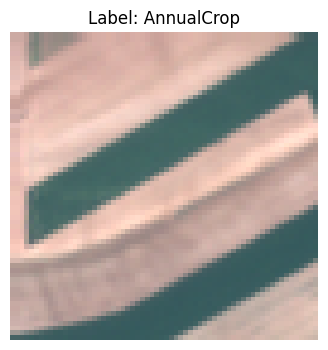

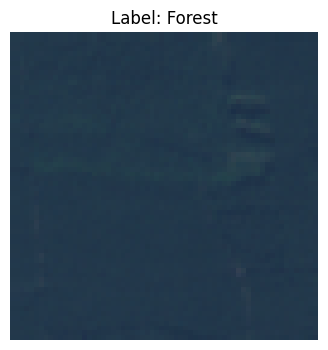

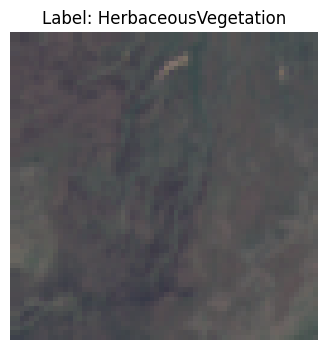

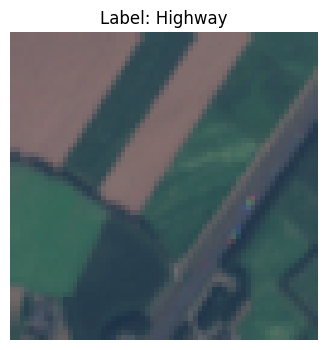

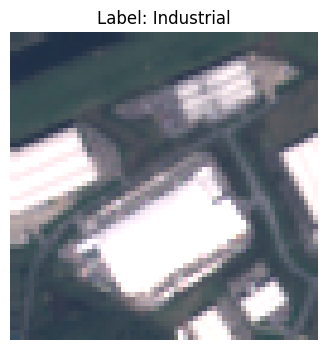

In [2]:
# Plot a few sample images
for i in range(0, 30, 6):
    train_dataset.plot(train_dataset[i])

### Building the TerraTorch training pipeline

Next, the TerraTorch training pipeline for this classification task is built. We initialize a new datamodule using the full EuroSat dataset.

In [3]:
from torchgeo.datamodules import EuroSATDataModule

datamodule = EuroSATDataModule(
    batch_size=8,
    num_workers=2,
    root="./eurosat",
    download=True,
)

datamodule.setup("fit")

train_dataset = datamodule.train_dataset
print(f"Available samples in the training dataset: {len(train_dataset)}")

Available samples in the training dataset: 16200


Next, we initialize the Lightning Trainer. TerraTorch builds on standard Lightning components, allowing us to use the regular Trainer and callbacks for fine-tuning. The training and validation logic itself is defined by EO-specific task classes provided by TerraTorch, which we initialize in the next step.

In [ ]:
import lightning.pytorch as pl

pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="output/prithvi_eurosat/",
    filename="best-val",
    save_weights_only=True,
)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    precision="bf16-mixed",  # speed up training with mixed precision
    max_epochs=1,            # train only one epoch for tutorial purposes
    logger=True,             # uses TensorBoard by default
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="output/prithvi_eurosat/",
)


In this example, we use the `ClassificationTask`. As backbone, we use the lightweight TerraMind tiny model with a single input modality. Since EuroSat provides L1C data, the TerraMind backbone is initialized accordingly.

For this classification task, no decoder is used. The backbone features are passed directly to a simple two-layer classification head that produces the class predictions.

In [ ]:
from terratorch.tasks import ClassificationTask

model = ClassificationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        "backbone": "terramind_v1_tiny",
        "backbone_pretrained": True,    # load pretrained weights
        "backbone_modalities": ["S2L1C"],
        "necks": [
            {
                "name": "ReshapeTokensToImage",
                "remove_cls_token": False,
            }
        ],
        "decoder": "IdentityDecoder",   # no decoder is used
        "head_dropout": 0.1,            # dropout in the classification head
        "head_dim_list": [128],         # hidden dimension of the head
        "num_classes": 10,              # EuroSat has 10 class labels
    },
    loss="ce",
    optimizer="AdamW",
    ignore_index=-1,
    lr=1e-4,                            # optimal learning rate varies between datasets, we recommend testing different once between 1e-5 and 1e-4.
    freeze_backbone=False,
)

In [6]:
# Start training
trainer.fit(model, datamodule=datamodule)

Epoch 1/1  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2025/2025 0:01:55 • 0:00:00 17.34it/s v_num: 0.000

`Trainer.fit` stopped: `max_epochs=2` reached.


In [7]:
# Prepare the test split
datamodule.setup("test")

test_dataset = datamodule.test_dataset
print(f"Number of samples in the test dataset: {len(test_dataset)}")

Number of samples in the test dataset: 5400


In [8]:
# Evaluate the model on the test set
_ = trainer.test(model=model, datamodule=datamodule)

Testing ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 675/675 0:00:11 • 0:00:00 56.83it/s

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/Accuracy       │    0.9368494153022766     │
│    test/Accuracy_Micro    │    0.9399999976158142     │
│   test/Class_Accuracy_0   │    0.9614093899726868     │
│   test/Class_Accuracy_1   │    0.9621710777282715     │
│   test/Class_Accuracy_2   │    0.9738219976425171     │
│   test/Class_Accuracy_3   │    0.8911290168762207     │
│   test/Class_Accuracy_4   │    0.9081836342811584     │
│   test/Class_Accuracy_5   │    0.9065656661987305     │
│   test/Class_Accuracy_6   │    0.9237918257713318     │
│   test/Class_Accuracy_7   │    0.9765343070030212     │
│   test/Class_Accuracy_8   │    0.8714555501937866     │
│   test/Class_Accuracy_9   │    0.9934318661689758     │
│      test/Class_F1_0      │    0.9646464586257935     │
│      test/Class_F1_1      │    0.9717608094215393     │
│      test/Class_F1_2      │     0.926141083240509     │
│      test/Class_F1_3      │    0.8615984320640564     │
│      test/Class_F1_4      │     0.93047034740448      │
│      test/Class_F1_5      │    0.9312580823898315     │
│      test/Class_F1_6      │     0.940397322177887     │
│      test/Class_F1_7      │    0.9311531782150269     │
│      test/Class_F1_8      │    0.9284995198249817     │
│      test/Class_F1_9      │    0.9950658082962036     │
│       test/F1_Score       │    0.9380990862846375     │
│      test/Precision       │    0.9415186643600464     │
│        test/Recall        │    0.9368494153022766     │
│         test/loss         │    0.19074930250644684    │
└───────────────────────────┴───────────────────────────┘

## Inference and visualization

Finally, we run inference on a batch from the test split and visualize a few predictions using the EuroSAT100DataModule. The same normalization statistics used during training are applied before passing the images through the model.

In [9]:
datamodule = EuroSAT100DataModule(
    root='./eurosat_100',
    download =True, 
   )

datamodule.setup("test")
test_dataset = datamodule.test_dataset
print(f"Number of samples in the test dataset: {len(test_dataset)}")

Number of samples in the test dataset: 20


In [10]:
import torch

test_loader = datamodule.test_dataloader()

with torch.no_grad():
    batch = next(iter(test_loader))
    # Apply the same normalization used during training
    batch = datamodule.aug(batch)

    images = batch["image"].to(model.device)

    outputs = model(images)
    preds = outputs.output.argmax(dim=1)

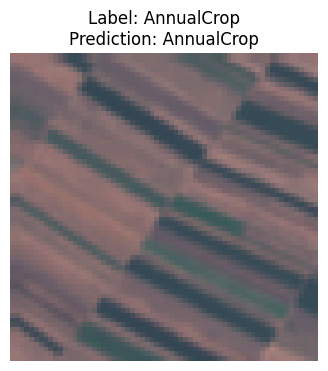

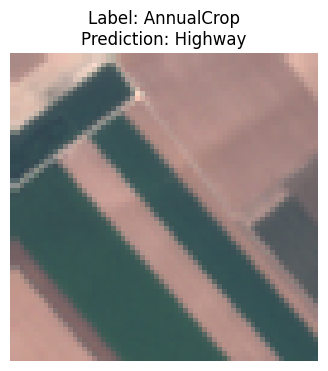

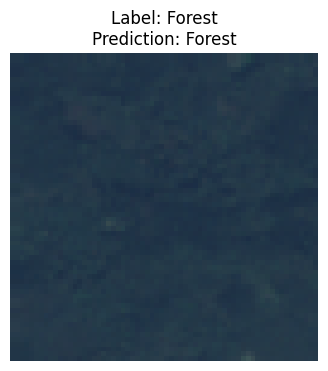

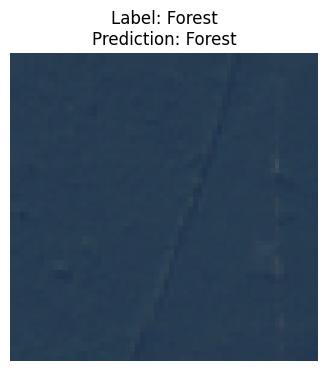

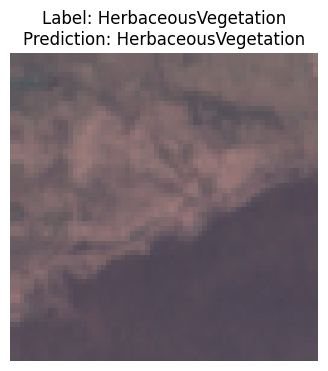

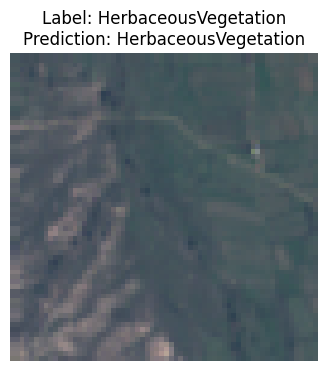

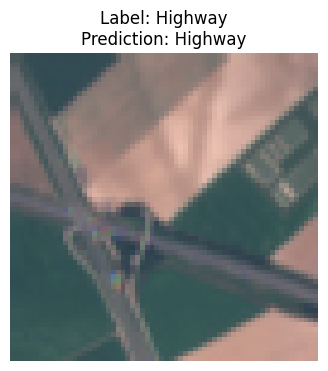

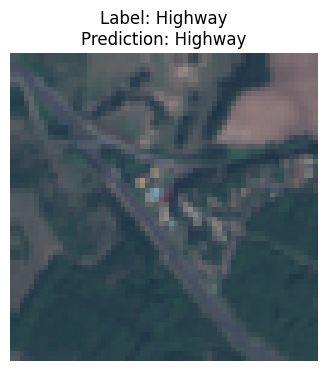

In [11]:
import matplotlib.pyplot as plt

# Visualize a few predictions
for i in range(8):
    sample = {
        "image": batch["image"][i].cpu(),
        "label": batch["label"][i],
        "prediction": preds[i],
    }

    test_dataset.plot(sample)
    plt.show()

## Training via CLI

Above, we introduced the required TerraTorch components and how to combine them flexibly. The same workflow can be run in a no-code setup by configuring all components in a YAML file and executing it via the PyTorch Lightning CLI.

We provide a sample YAML with the Prithvi v2 300 model that can serve as a starting point for similar pipelines.

**Note:** You may want to restart the session to free up memory before running the CLI workflow.

In [ ]:
# Run fine-tuning
!terratorch fit -c classification_eurosat.yaml